## Sample 0 contig pairs from MetaBAT2

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import math
import torch
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import torch.utils.data
from dataset import SiameseData
from network import EmbeddingNet, SiameseNet
from losses import ContrastiveLoss
import torch.optim as optim
from torch.optim import lr_scheduler
from trainer import fit, test_epoch
import matplotlib.pyplot as plt
import numpy as np
from metrics import AccumulatedAccuracyMetric, SiameseAccuracyMetric
import time

In [2]:
feature_vectors = pd.read_csv('../data/3-mer/train.csv', header=None)
feature_vectors

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,130,103,84,55,73,108,31,33,56,73,...,48,71,48,83,43,18,79,21,57,0
1,93,82,80,43,54,84,58,35,52,66,...,41,77,64,93,40,20,54,19,51,0
2,76,63,87,38,56,90,58,22,48,60,...,45,78,90,106,32,9,50,22,40,0
3,99,78,90,41,65,77,54,35,66,60,...,47,82,52,115,50,10,68,31,48,0
4,111,59,90,39,43,75,52,41,44,54,...,45,80,70,103,40,20,64,38,60,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446,3,29,23,7,24,76,78,19,30,86,...,19,33,74,66,44,0,18,39,1,16
18447,2,26,25,2,11,102,84,19,22,67,...,23,48,82,78,35,0,25,43,0,16
18448,1,18,10,1,11,111,102,19,5,42,...,15,23,66,91,34,0,29,11,0,16
18449,10,32,30,4,28,108,86,16,32,73,...,22,38,76,76,22,5,33,11,4,16


In [90]:
feature_vectors_0 = feature_vectors.loc[feature_vectors.iloc[:, -1] <= 9]
X = feature_vectors_0.iloc[:, :-1]
X

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,130,103,84,55,73,108,31,33,56,73,...,32,48,71,48,83,43,18,79,21,57
1,93,82,80,43,54,84,58,35,52,66,...,25,41,77,64,93,40,20,54,19,51
2,76,63,87,38,56,90,58,22,48,60,...,41,45,78,90,106,32,9,50,22,40
3,99,78,90,41,65,77,54,35,66,60,...,31,47,82,52,115,50,10,68,31,48
4,111,59,90,39,43,75,52,41,44,54,...,42,45,80,70,103,40,20,64,38,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10713,266,71,80,201,68,36,11,62,61,42,...,14,80,63,49,21,56,176,67,67,219
10714,188,72,72,161,68,44,20,72,40,42,...,20,83,66,52,19,57,185,66,93,239
10715,203,81,78,184,75,29,26,88,66,45,...,10,70,64,33,18,50,209,81,64,246
10716,154,72,61,160,63,28,25,79,67,43,...,22,71,54,59,38,55,189,86,81,240


In [91]:
Y = feature_vectors_0.iloc[:, -1]
Y

0        0
1        0
2        0
3        0
4        0
        ..
10713    9
10714    9
10715    9
10716    9
10717    9
Name: 64, Length: 10718, dtype: int64

In [5]:
dataset = feature_vectors_0.values
X = dataset[:, :-1]
Y = dataset[:, -1]

### Preprocessing data

In [3]:
# parameters
seed = 7
batch_size = 128
cuda = torch.cuda.is_available()
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
SIAMESE_PATH = '../models/3-mer/siamese_net.pth'

In [36]:
# split dataset to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_train, X_test = preprocessing.MinMaxScaler().fit_transform(X_train), preprocessing.MinMaxScaler().fit_transform(
        X_test)
X_train, Y_train = torch.FloatTensor(X_train), torch.LongTensor(Y_train)
X_test, Y_test = torch.FloatTensor(X_test), torch.LongTensor(Y_test)

X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

# construct dataset
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

# load data set
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# construct dataset in pairs
siamese_train_dataset = SiameseData(dataset=train_dataset, train=True)
siamese_test_dataset = SiameseData(dataset=test_dataset, train=False)

# load data set in pairs
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True,
                                                       **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False,
                                                      **kwargs)

### Train the model

In [26]:
# visulization
def plot_model_history(loss_train, loss_test, accuracy_train, accuracy_test):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # loss of model
    axs[0].plot(range(1, len(loss_train) + 1), loss_train)
    axs[0].plot(range(1, len(loss_test) + 1), loss_test)
    axs[0].set_title('Model Loss')
    axs[0].set_ylabel('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(loss_train) + 1), len(loss_train) / 10)
    axs[0].legend(['train', 'val'], loc='best')
    # accuracy of model
    axs[1].plot(range(1, len(accuracy_train) + 1), accuracy_train)
    axs[1].plot(range(1, len(accuracy_test) + 1), accuracy_test)
    axs[1].set_title('Model Accuracy')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(accuracy_train) + 1), len(accuracy_train) / 10)
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig('../images/' + time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()) + '.png')

Train: [0/8574 (0%)]	Loss: 6.834709	Accuracy: 62.5
Epoch: 1/20. Train set: Average loss: 2.8312	Accuracy: 72.27665033823186
Epoch: 1/20. Validation set: Average loss: 2.0101	Accuracy: 66.27798507462687
Train: [0/8574 (0%)]	Loss: 2.012697	Accuracy: 71.09375
Epoch: 2/20. Train set: Average loss: 1.5938	Accuracy: 80.18427804991836
Epoch: 2/20. Validation set: Average loss: 1.3687	Accuracy: 74.30037313432835
Train: [0/8574 (0%)]	Loss: 1.274338	Accuracy: 87.5
Epoch: 3/20. Train set: Average loss: 1.2078	Accuracy: 85.81758805691626
Epoch: 3/20. Validation set: Average loss: 1.1366	Accuracy: 74.81343283582089
Train: [0/8574 (0%)]	Loss: 1.017890	Accuracy: 88.28125
Epoch: 4/20. Train set: Average loss: 1.0597	Accuracy: 88.0569162584558
Epoch: 4/20. Validation set: Average loss: 1.0432	Accuracy: 78.40485074626865
Train: [0/8574 (0%)]	Loss: 1.277167	Accuracy: 84.375
Epoch: 5/20. Train set: Average loss: 0.9377	Accuracy: 88.81502216001866
Epoch: 5/20. Validation set: Average loss: 0.9818	Accuracy:

/opt/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/opt/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


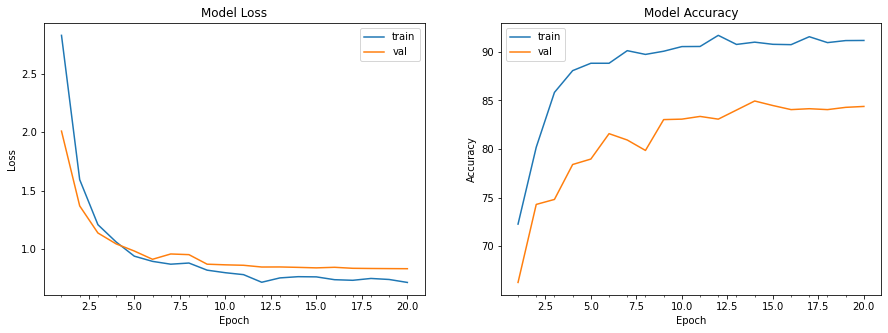

In [38]:
# initilize model
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)

# GPU acceleration
if cuda:
    model.cuda()

# define loss function
margin = 5
loss_fn = ContrastiveLoss(margin)

# initilize optimizer
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

# train the model
loss_values_train, loss_values_test, accuracy_values_train, accuracy_values_test = fit(siamese_train_loader,
                                                                                       siamese_test_loader,
                                                                                       model, loss_fn,
                                                                                       optimizer, scheduler,
                                                                                       n_epochs, cuda,
                                                                                       log_interval, metrics=[SiameseAccuracyMetric()])

# save the model parameters
torch.save(model.state_dict(), SIAMESE_PATH)

# save model losses result
plot_model_history(loss_values_train, loss_values_test, accuracy_values_train, accuracy_values_test)

### Test the data

In [4]:
test_vectors = pd.read_csv('../data/test_dataset/3-mer/test.csv', header=None)
test_vectors

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0.645161,0.485075,0.426573,0.627329,0.313869,0.209756,0.129496,0.346457,0.365079,0.113924,...,0.267516,0.562500,0.279279,0.533742,0.533898,0.377907,0.555556,0.848684,0.666667,8.0
1,0.329749,0.544776,0.608392,0.329193,0.386861,0.258537,0.338129,0.314961,0.587302,0.449367,...,0.439490,0.460938,0.477477,0.355828,0.271186,0.116279,0.444444,0.407895,0.263492,0.0
2,0.379928,0.440299,0.482517,0.447205,0.408759,0.146341,0.359712,0.259843,0.515873,0.487342,...,0.197452,0.593750,0.513514,0.306748,0.491525,0.151163,0.313725,0.500000,0.177778,4.0
3,0.014337,0.171642,0.041958,0.000000,0.109489,0.370732,0.453237,0.086614,0.095238,0.240506,...,0.038217,0.210938,0.576577,0.791411,0.211864,0.000000,0.176471,0.059211,0.006349,6.0
4,0.017921,0.253731,0.111888,0.031056,0.175182,0.463415,0.510791,0.149606,0.198413,0.544304,...,0.140127,0.304688,0.432432,0.380368,0.135593,0.000000,0.202614,0.085526,0.003175,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5975,0.003584,0.194030,0.118881,0.006211,0.145985,0.570732,0.553957,0.236220,0.134921,0.386076,...,0.114650,0.218750,0.549550,0.435583,0.245763,0.005814,0.202614,0.111842,0.009524,5.0
5976,0.035842,0.194030,0.118881,0.031056,0.218978,0.434146,0.589928,0.157480,0.246032,0.360759,...,0.121019,0.226562,0.252252,0.233129,0.101695,0.040698,0.209150,0.059211,0.015873,5.0
5977,0.010753,0.119403,0.118881,0.000000,0.094891,0.404878,0.431655,0.157480,0.134921,0.272152,...,0.152866,0.257812,0.585586,0.558282,0.110169,0.005814,0.143791,0.111842,0.006349,5.0
5978,0.229391,0.328358,0.510490,0.267081,0.255474,0.219512,0.345324,0.141732,0.428571,0.303797,...,0.420382,0.593750,0.495495,0.404908,0.398305,0.063953,0.470588,0.585526,0.215873,0.0


In [5]:
# parameters
classes = ['Cohaesibacter sp', 'Halomonas sp HL-4', 'Halomonas sp HL-93',
           'Marinobacter sp1', 'Marinobacter sp8', 'M coxensis',
           'M echinaurantiaca', 'M echinofusca ', 'Muricauda sp',
           'Propionibact b', 'Psychrobacter sp', 'Thioclava sp']

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf', '#99ff99', '#000099']
n_classes = 12

In [6]:
# visualization
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10, 10))
    for i in range(n_classes):
        inds = np.where(targets == i)[0]
        plt.scatter(embeddings[inds, 0], embeddings[inds, 1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.ylim(ylim[0], ylim[1])
    plt.legend(classes)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 2))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for seq, target in dataloader:
            if cuda:
                seq = seq.cuda()
            embeddings[k:k + len(seq)] = model.get_embedding(seq).data.cpu().numpy()
            labels[k:k + len(seq)] = target.numpy()
            k += len(seq)
    return embeddings, labels

In [7]:
# data preprocessing
dataset = test_vectors.values
X = dataset[:, :-1]
Y = dataset[:, -1]

X = preprocessing.MinMaxScaler().fit_transform(X)
X = torch.FloatTensor(X)
X, Y = torch.FloatTensor(X), torch.LongTensor(Y)

X = X.unsqueeze(1)

# construct dataset
test_dataset = torch.utils.data.TensorDataset(X, Y)

# load data set
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# construct dataset in pairs
siamese_test_dataset = SiameseData(dataset=test_dataset, train=False)

# load data set in pairs
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False,
                                                  **kwargs)

In [8]:
# initilize model
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)

# load the model parameters
model.load_state_dict(torch.load(SIAMESE_PATH))

# define loss function
margin = 5
loss_fn = ContrastiveLoss(margin)

val_loss, metrics = test_epoch(siamese_test_loader, model, loss_fn, cuda, metrics=[SiameseAccuracyMetric()])
print('length of test dataset: ' + str(len(siamese_test_dataset)))
for metric in metrics:
    print(str(metric.name()) + "  " + str(metric.value()))
    print('confusion matrix:')
    print(metric.confusion_matrix())

# plot embedding vectors
val_embeddings_cl, val_labels_cl = extract_embeddings(test_loader, model)
plot_embeddings(val_embeddings_cl, val_labels_cl)

NameError: name 'siamese_train_dataset' is not defined

## Sample 20% pairs from MetaBAT2

In [38]:
feature_vectors_20 = feature_vectors.loc[feature_vectors.iloc[:, -1] > 10].sample(frac=0.2, replace=False, random_state=1)
feature_vectors_20 = pd.concat([feature_vectors_0, feature_vectors_20], ignore_index=True) 
X = feature_vectors_20.iloc[:, :-1]
Y = feature_vectors_20.iloc[:, -1]

In [23]:
dataset = feature_vectors_20.values
X = dataset[:, :-1]
Y = dataset[:, -1]
print(X)
print(Y)

[[130 103  84 ...  79  21  57]
 [ 93  82  80 ...  54  19  51]
 [ 76  63  87 ...  50  22  40]
 ...
 [  0  27  30 ...  32   3   0]
 [  1  32  20 ...  35  19   1]
 [  1  22  20 ...  26  32   1]]
[ 0  0  0 ... 14 14 16]


In [24]:
# split dataset to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_train, X_test = preprocessing.MinMaxScaler().fit_transform(X_train), preprocessing.MinMaxScaler().fit_transform(
        X_test)
X_train, Y_train = torch.FloatTensor(X_train), torch.LongTensor(Y_train)
X_test, Y_test = torch.FloatTensor(X_test), torch.LongTensor(Y_test)

X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

# construct dataset
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

# load data set
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# construct dataset in pairs
siamese_train_dataset = SiameseData(dataset=train_dataset, train=True)
siamese_test_dataset = SiameseData(dataset=test_dataset, train=False)

# load data set in pairs
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True,
                                                       **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False,
                                                      **kwargs)

Train: [0/9711 (0%)]	Loss: 6.639016	Accuracy: 62.5
Epoch: 1/20. Train set: Average loss: 2.3379	Accuracy: 75.94480486046751
Epoch: 1/20. Validation set: Average loss: 1.6286	Accuracy: 67.1334431630972
Train: [0/9711 (0%)]	Loss: 1.351691	Accuracy: 75.78125
Epoch: 2/20. Train set: Average loss: 1.3448	Accuracy: 78.01462259293585
Epoch: 2/20. Validation set: Average loss: 1.1929	Accuracy: 67.833607907743
Train: [0/9711 (0%)]	Loss: 0.940735	Accuracy: 83.59375
Epoch: 3/20. Train set: Average loss: 1.0304	Accuracy: 84.3682421995675
Epoch: 3/20. Validation set: Average loss: 1.0538	Accuracy: 71.12850082372323
Train: [0/9711 (0%)]	Loss: 0.949260	Accuracy: 86.71875
Epoch: 4/20. Train set: Average loss: 0.9391	Accuracy: 85.31562146019978
Epoch: 4/20. Validation set: Average loss: 0.9292	Accuracy: 76.02965403624383
Train: [0/9711 (0%)]	Loss: 0.986314	Accuracy: 87.5
Epoch: 5/20. Train set: Average loss: 0.7964	Accuracy: 88.01359283286995
Epoch: 5/20. Validation set: Average loss: 0.8670	Accuracy: 

/home/jli347/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/home/jli347/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


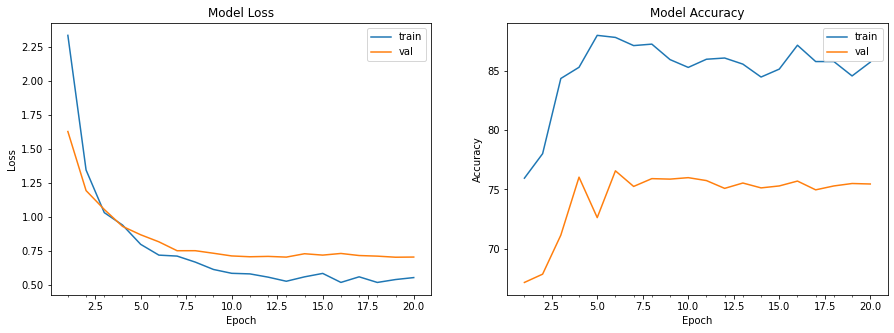

In [27]:
# initilize model
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)

# GPU acceleration
if cuda:
    model.cuda()

# define loss function
margin = 5
loss_fn = ContrastiveLoss(margin)

# initilize optimizer
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

# train the model
loss_values_train, loss_values_test, accuracy_values_train, accuracy_values_test = fit(siamese_train_loader,
                                                                                       siamese_test_loader,
                                                                                       model, loss_fn,
                                                                                       optimizer, scheduler,
                                                                                       n_epochs, cuda,
                                                                                       log_interval, metrics=[SiameseAccuracyMetric()])

# save the model parameters
torch.save(model.state_dict(), SIAMESE_PATH)

# save model losses result
plot_model_history(loss_values_train, loss_values_test, accuracy_values_train, accuracy_values_test)

## Sample 40% pairs from MetaBAT2

In [58]:
feature_vectors_40 = feature_vectors.loc[feature_vectors.iloc[:, -1] > 10].sample(frac=0.4, replace=False, random_state=1)
feature_vectors_40 = pd.concat([feature_vectors_0, feature_vectors_40], ignore_index=True) 
X = feature_vectors_40.iloc[:, :-1]
Y = feature_vectors_40.iloc[:, -1]

In [59]:
dataset = feature_vectors_40.values
X = dataset[:, :-1]
Y = dataset[:, -1]
print(X)
print(Y)

[[130 103  84 ...  79  21  57]
 [ 93  82  80 ...  54  19  51]
 [ 76  63  87 ...  50  22  40]
 ...
 [  0  22  16 ...  19  18   1]
 [  4  22  24 ...  20  18   3]
 [  4  27  14 ...  44   7   3]]
[ 0  0  0 ... 16 14 12]


In [60]:
# split dataset to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_train, X_test = preprocessing.MinMaxScaler().fit_transform(X_train), preprocessing.MinMaxScaler().fit_transform(
        X_test)
X_train, Y_train = torch.FloatTensor(X_train), torch.LongTensor(Y_train)
X_test, Y_test = torch.FloatTensor(X_test), torch.LongTensor(Y_test)

X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

# construct dataset
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

# load data set
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# construct dataset in pairs
siamese_train_dataset = SiameseData(dataset=train_dataset, train=True)
siamese_test_dataset = SiameseData(dataset=test_dataset, train=False)

# load data set in pairs
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True,
                                                       **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False,
                                                      **kwargs)

Train: [0/10848 (0%)]	Loss: 5.564787	Accuracy: 67.96875
Epoch: 1/20. Train set: Average loss: 2.1389	Accuracy: 77.24926253687316
Epoch: 1/20. Validation set: Average loss: 1.5994	Accuracy: 67.18289085545723
Train: [0/10848 (0%)]	Loss: 1.581225	Accuracy: 75.0
Epoch: 2/20. Train set: Average loss: 1.3862	Accuracy: 77.5811209439528
Epoch: 2/20. Validation set: Average loss: 1.2460	Accuracy: 68.06784660766962
Train: [0/10848 (0%)]	Loss: 1.242486	Accuracy: 77.34375
Epoch: 3/20. Train set: Average loss: 1.0745	Accuracy: 80.46644542772862
Epoch: 3/20. Validation set: Average loss: 0.9913	Accuracy: 71.20206489675516
Train: [0/10848 (0%)]	Loss: 0.888831	Accuracy: 84.375
Epoch: 4/20. Train set: Average loss: 0.9040	Accuracy: 83.84033923303835
Epoch: 4/20. Validation set: Average loss: 0.8948	Accuracy: 70.57522123893806
Train: [0/10848 (0%)]	Loss: 0.801265	Accuracy: 88.28125
Epoch: 5/20. Train set: Average loss: 0.7898	Accuracy: 86.1080383480826
Epoch: 5/20. Validation set: Average loss: 0.7806	A

/home/jli347/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/home/jli347/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


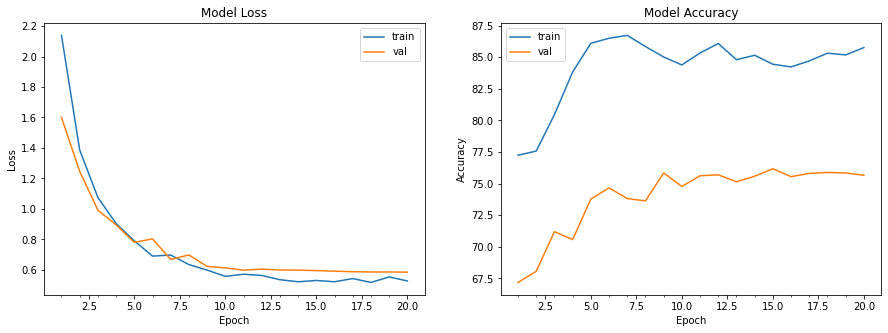

In [61]:
# initilize model
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)

# GPU acceleration
if cuda:
    model.cuda()

# define loss function
margin = 5
loss_fn = ContrastiveLoss(margin)

# initilize optimizer
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

# train the model
loss_values_train, loss_values_test, accuracy_values_train, accuracy_values_test = fit(siamese_train_loader,
                                                                                       siamese_test_loader,
                                                                                       model, loss_fn,
                                                                                       optimizer, scheduler,
                                                                                       n_epochs, cuda,
                                                                                       log_interval, metrics=[SiameseAccuracyMetric()])

# save the model parameters
torch.save(model.state_dict(), SIAMESE_PATH)

# save model losses result
plot_model_history(loss_values_train, loss_values_test, accuracy_values_train, accuracy_values_test)

## Sample 60% pairs from MetaBAT2

In [67]:
feature_vectors_60 = feature_vectors.loc[feature_vectors.iloc[:, -1] > 10].sample(frac=0.6, replace=False, random_state=1)
feature_vectors_60 = pd.concat([feature_vectors_0, feature_vectors_60], ignore_index=True) 
X = feature_vectors_60.iloc[:, :-1]
Y = feature_vectors_60.iloc[:, -1]

In [68]:
dataset = feature_vectors_60.values
X = dataset[:, :-1]
Y = dataset[:, -1]
print(X)
print(Y)

[[130 103  84 ...  79  21  57]
 [ 93  82  80 ...  54  19  51]
 [ 76  63  87 ...  50  22  40]
 ...
 [  5  25  47 ...  41  49   3]
 [  0  23  16 ...  26  11   2]
 [  6  31  37 ...  29  12   5]]
[ 0  0  0 ... 16 14 14]


In [69]:
# split dataset to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_train, X_test = preprocessing.MinMaxScaler().fit_transform(X_train), preprocessing.MinMaxScaler().fit_transform(
        X_test)
X_train, Y_train = torch.FloatTensor(X_train), torch.LongTensor(Y_train)
X_test, Y_test = torch.FloatTensor(X_test), torch.LongTensor(Y_test)

X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

# construct dataset
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

# load data set
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# construct dataset in pairs
siamese_train_dataset = SiameseData(dataset=train_dataset, train=True)
siamese_test_dataset = SiameseData(dataset=test_dataset, train=False)

# load data set in pairs
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True,
                                                       **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False,
                                                      **kwargs)

Train: [0/11985 (0%)]	Loss: 4.686667	Accuracy: 60.15625
Epoch: 1/20. Train set: Average loss: 2.1262	Accuracy: 76.13683771380893
Epoch: 1/20. Validation set: Average loss: 1.5989	Accuracy: 66.29963296629963
Train: [0/11985 (0%)]	Loss: 1.462034	Accuracy: 72.65625
Epoch: 2/20. Train set: Average loss: 1.3300	Accuracy: 76.79599499374218
Epoch: 2/20. Validation set: Average loss: 1.3704	Accuracy: 64.59793126459793
Train: [0/11985 (0%)]	Loss: 1.684986	Accuracy: 67.1875
Epoch: 3/20. Train set: Average loss: 1.1456	Accuracy: 77.3884021693784
Epoch: 3/20. Validation set: Average loss: 1.1566	Accuracy: 69.80313646980314
Train: [0/11985 (0%)]	Loss: 1.051100	Accuracy: 77.34375
Epoch: 4/20. Train set: Average loss: 0.9676	Accuracy: 78.80684188569045
Epoch: 4/20. Validation set: Average loss: 1.0225	Accuracy: 67.30063396730064
Train: [0/11985 (0%)]	Loss: 0.849151	Accuracy: 81.25
Epoch: 5/20. Train set: Average loss: 0.8926	Accuracy: 80.25865665415103
Epoch: 5/20. Validation set: Average loss: 1.000

/home/jli347/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/home/jli347/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


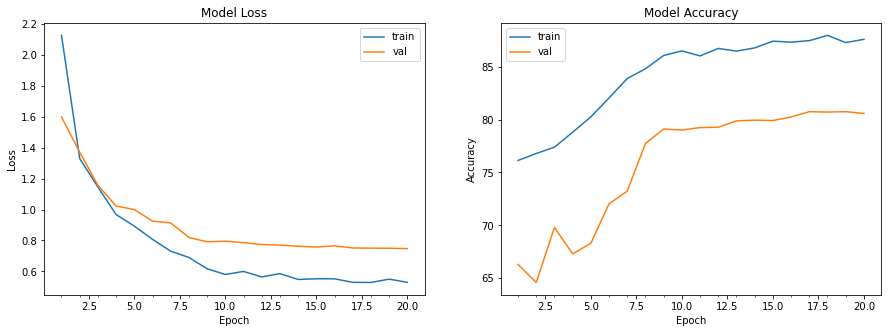

In [70]:
# initilize model
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)

# GPU acceleration
if cuda:
    model.cuda()

# define loss function
margin = 5
loss_fn = ContrastiveLoss(margin)

# initilize optimizer
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

# train the model
loss_values_train, loss_values_test, accuracy_values_train, accuracy_values_test = fit(siamese_train_loader,
                                                                                       siamese_test_loader,
                                                                                       model, loss_fn,
                                                                                       optimizer, scheduler,
                                                                                       n_epochs, cuda,
                                                                                       log_interval, metrics=[SiameseAccuracyMetric()])

# save the model parameters
torch.save(model.state_dict(), SIAMESE_PATH)

# save model losses result
plot_model_history(loss_values_train, loss_values_test, accuracy_values_train, accuracy_values_test)

## Sample 80% pairs from MetaBAT2

In [80]:
feature_vectors_80 = feature_vectors.loc[feature_vectors.iloc[:, -1] > 10].sample(frac=0.8, replace=False, random_state=1)
feature_vectors_80 = pd.concat([feature_vectors_0, feature_vectors_80], ignore_index=True) 
X = feature_vectors_80.iloc[:, :-1]
Y = feature_vectors_80.iloc[:, -1]

In [81]:
dataset = feature_vectors_80.values
X = dataset[:, :-1]
Y = dataset[:, -1]
print(X)
print(Y)

[[130 103  84 ...  79  21  57]
 [ 93  82  80 ...  54  19  51]
 [ 76  63  87 ...  50  22  40]
 ...
 [  0  45  35 ...  46   2   1]
 [  4  27  11 ...  31  13   2]
 [  2  27  14 ...  31   9   1]]
[ 0  0  0 ... 14 16 14]


In [82]:
# split dataset to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_train, X_test = preprocessing.MinMaxScaler().fit_transform(X_train), preprocessing.MinMaxScaler().fit_transform(
        X_test)
X_train, Y_train = torch.FloatTensor(X_train), torch.LongTensor(Y_train)
X_test, Y_test = torch.FloatTensor(X_test), torch.LongTensor(Y_test)

X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

# construct dataset
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

# load data set
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# construct dataset in pairs
siamese_train_dataset = SiameseData(dataset=train_dataset, train=True)
siamese_test_dataset = SiameseData(dataset=test_dataset, train=False)

# load data set in pairs
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True,
                                                       **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False,
                                                      **kwargs)

Train: [0/13122 (0%)]	Loss: 5.076493	Accuracy: 66.40625
Train: [12800/13122 (97%)]	Loss: 1.877661	Accuracy: 78.17914603960396
Epoch: 1/20. Train set: Average loss: 1.9052	Accuracy: 78.14357567443987
Epoch: 1/20. Validation set: Average loss: 1.3187	Accuracy: 69.39957330082292
Train: [0/13122 (0%)]	Loss: 1.182376	Accuracy: 79.6875
Train: [12800/13122 (97%)]	Loss: 1.085896	Accuracy: 81.79146039603961
Epoch: 2/20. Train set: Average loss: 1.0790	Accuracy: 81.9311080627953
Epoch: 2/20. Validation set: Average loss: 1.0387	Accuracy: 70.19201462968607
Train: [0/13122 (0%)]	Loss: 0.898678	Accuracy: 79.6875
Train: [12800/13122 (97%)]	Loss: 0.935459	Accuracy: 83.29207920792079
Epoch: 3/20. Train set: Average loss: 0.9337	Accuracy: 83.2571254381954
Epoch: 3/20. Validation set: Average loss: 0.9040	Accuracy: 72.05120390124962
Train: [0/13122 (0%)]	Loss: 0.725134	Accuracy: 80.46875
Train: [12800/13122 (97%)]	Loss: 0.838039	Accuracy: 84.00371287128714
Epoch: 4/20. Train set: Average loss: 0.8351	Ac

/home/jli347/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/home/jli347/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


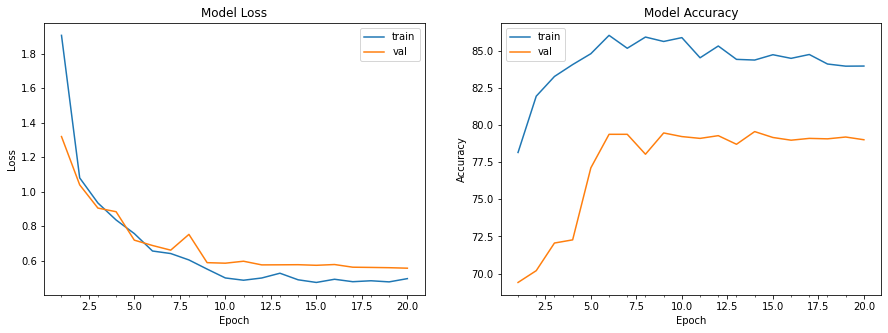

In [83]:
# initilize model
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)

# GPU acceleration
if cuda:
    model.cuda()

# define loss function
margin = 5
loss_fn = ContrastiveLoss(margin)

# initilize optimizer
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

# train the model
loss_values_train, loss_values_test, accuracy_values_train, accuracy_values_test = fit(siamese_train_loader,
                                                                                       siamese_test_loader,
                                                                                       model, loss_fn,
                                                                                       optimizer, scheduler,
                                                                                       n_epochs, cuda,
                                                                                       log_interval, metrics=[SiameseAccuracyMetric()])

# save the model parameters
torch.save(model.state_dict(), SIAMESE_PATH)

# save model losses result
plot_model_history(loss_values_train, loss_values_test, accuracy_values_train, accuracy_values_test)

## Add all data from MetaBAT2 to training data

In [93]:
feature_vectors = pd.read_csv('../data/3-mer/train.csv', header=None)
feature_vectors

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,130,103,84,55,73,108,31,33,56,73,...,48,71,48,83,43,18,79,21,57,0
1,93,82,80,43,54,84,58,35,52,66,...,41,77,64,93,40,20,54,19,51,0
2,76,63,87,38,56,90,58,22,48,60,...,45,78,90,106,32,9,50,22,40,0
3,99,78,90,41,65,77,54,35,66,60,...,47,82,52,115,50,10,68,31,48,0
4,111,59,90,39,43,75,52,41,44,54,...,45,80,70,103,40,20,64,38,60,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446,3,29,23,7,24,76,78,19,30,86,...,19,33,74,66,44,0,18,39,1,16
18447,2,26,25,2,11,102,84,19,22,67,...,23,48,82,78,35,0,25,43,0,16
18448,1,18,10,1,11,111,102,19,5,42,...,15,23,66,91,34,0,29,11,0,16
18449,10,32,30,4,28,108,86,16,32,73,...,22,38,76,76,22,5,33,11,4,16


In [94]:
dataset = feature_vectors.values
X = dataset[:, :-1]
Y = dataset[:, -1]

In [97]:
# split dataset to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_train, X_test = preprocessing.MinMaxScaler().fit_transform(X_train), preprocessing.MinMaxScaler().fit_transform(
        X_test)
X_train, Y_train = torch.FloatTensor(X_train), torch.LongTensor(Y_train)
X_test, Y_test = torch.FloatTensor(X_test), torch.LongTensor(Y_test)

X_train = X_train.unsqueeze(1)
X_test = X_test.unsqueeze(1)

# construct dataset
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)

# load data set
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

# construct dataset in pairs
siamese_train_dataset = SiameseData(dataset=train_dataset, train=True)
siamese_test_dataset = SiameseData(dataset=test_dataset, train=False)

# load data set in pairs
siamese_train_loader = torch.utils.data.DataLoader(siamese_train_dataset, batch_size=batch_size, shuffle=True,
                                                       **kwargs)
siamese_test_loader = torch.utils.data.DataLoader(siamese_test_dataset, batch_size=batch_size, shuffle=False,
                                                      **kwargs)

Train: [0/14760 (0%)]	Loss: 6.346366	Accuracy: 57.8125
Train: [12800/14760 (86%)]	Loss: 1.885761	Accuracy: 79.99690594059406
Epoch: 1/20. Train set: Average loss: 1.8464	Accuracy: 80.1490514905149
Epoch: 1/20. Validation set: Average loss: 1.1901	Accuracy: 72.22974803576267
Train: [0/14760 (0%)]	Loss: 0.929353	Accuracy: 83.59375
Train: [12800/14760 (86%)]	Loss: 1.118607	Accuracy: 84.68440594059406
Epoch: 2/20. Train set: Average loss: 1.0931	Accuracy: 84.87127371273712
Epoch: 2/20. Validation set: Average loss: 0.9745	Accuracy: 70.41452180980764
Train: [0/14760 (0%)]	Loss: 1.054938	Accuracy: 82.8125
Train: [12800/14760 (86%)]	Loss: 0.888152	Accuracy: 87.39944306930693
Epoch: 3/20. Train set: Average loss: 0.8854	Accuracy: 87.29674796747967
Epoch: 3/20. Validation set: Average loss: 0.8790	Accuracy: 74.23462476293687
Train: [0/14760 (0%)]	Loss: 0.882103	Accuracy: 89.0625
Train: [12800/14760 (86%)]	Loss: 0.786475	Accuracy: 88.22710396039604
Epoch: 4/20. Train set: Average loss: 0.7956	Ac

/home/jli347/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/home/jli347/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing the minor parameter of set_ticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


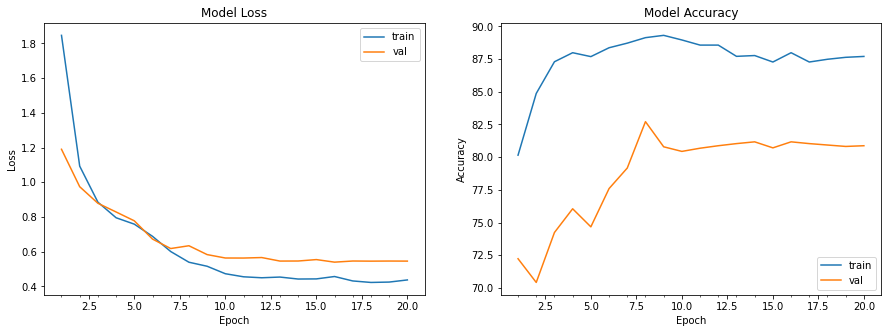

In [98]:
# initilize model
embedding_net = EmbeddingNet()
model = SiameseNet(embedding_net)

# GPU acceleration
if cuda:
    model.cuda()

# define loss function
margin = 5
loss_fn = ContrastiveLoss(margin)

# initilize optimizer
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 20
log_interval = 100

# train the model
loss_values_train, loss_values_test, accuracy_values_train, accuracy_values_test = fit(siamese_train_loader,
                                                                                       siamese_test_loader,
                                                                                       model, loss_fn,
                                                                                       optimizer, scheduler,
                                                                                       n_epochs, cuda,
                                                                                       log_interval, metrics=[SiameseAccuracyMetric()])

# save the model parameters
torch.save(model.state_dict(), SIAMESE_PATH)

# save model losses result
plot_model_history(loss_values_train, loss_values_test, accuracy_values_train, accuracy_values_test)

# Summary

In [104]:
percentage = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
accuracy = [0.63, 0.70, 0.72, 0.72, 0.74, 0.78]
precision = [0.41, 0.45, 0.70, 0.73, 0.72, 0.76]

/home/jli347/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  after removing the cwd from sys.path.
/home/jli347/miniconda3/envs/python37/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  """


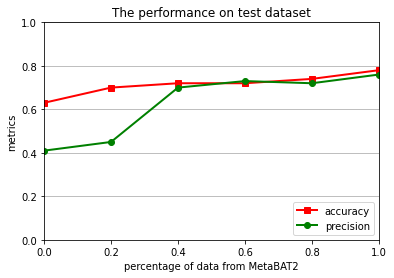

In [107]:
plt.xlim([0, 1.0])
plt.ylim([0.0, 1.0])
lw=2
plt.plot(percentage, accuracy, color='red', lw=lw, label='accuracy', Marker='s')
plt.plot(percentage, precision, color='green', lw=lw, label='precision', linestyle='-', Marker='o')
plt.grid(b=True, axis='y') #只显示y轴网格线
plt.xlabel("percentage of data from MetaBAT2")
plt.ylabel("metrics")
plt.title("The performance on test dataset")
plt.legend(loc="lower right")#  lower   right